In [458]:
import sys,os, glob
import numpy as np
import pandas as pd

from shutil import copyfile

import cv2
from matplotlib import pyplot as plt

In [466]:
# CONFIGS (working on UKBB images)

LWNETDIR="/HDD/data/UKBB/fundus/lwnet/"

MASK_RADIUS=660 # works for UKBB images
RESIZE_RADIUS=500 # normalization factor to standardize images at size
BLOT_THRESHOLD=0.12 # what luminosity will be a blot
LIGHT_BLOT_THRESHOLD=0.95
DILATION_SIZE = 1 # in case one wants to dilate the raw blot -> set larger than 1

MAX_MEAN = 165
MAX_SDEV = 0.4
MAX_BLOTSIZE = 30000
MIN_VASCULATURE = 1.52
MAX_LIGHTBLOTSIZE=33

In [621]:
# FUNCTIONS

def keep_throw(df,col,threshold, lower=True):

  if lower == True:
    return (df[df[col] <= threshold], df[df[col] > threshold])
  else:
    return (df[df[col] >= threshold], df[df[col] < threshold])

def n_participants(files):
  return len(set([i.split("_")[0] for i in files]))

def fileinfo(file):
  img=plt.imread(rawdir+file)
  plt.imshow(img)
  print(stats.loc[file])

def cp_content(src,dst,files,lwnet=True):

  rmfiles = glob.glob(dst+'*')
  for f in rmfiles:
    os.remove(f)

  for i in files:
    copyfile(src+i, dst+i)
    if lwnet==True:
      try:
        copyfile(LWNETDIR+i, dst+i.split(".png")[0]+"_seg.png")
      except:
        pass


def compare_image(image1, image2):
  plt.figure(figsize=(9,9))
  plt.subplot(1,2,1)
  plt.imshow(image1)
  plt.title('Orignal')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(image2)
  plt.title('Modified')
  plt.axis('off')

  plt.tight_layout()

def mask_image(img, toGray=False):
  hh,ww=img.shape[:2]
  #print(hh//2,ww//2)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  mask = np.zeros_like(gray)
  mask = cv2.circle(mask, (ww//2,hh//2), RESIZE_RADIUS, (255,255,255), -1)
  #mask = np.invert(mask.astype(bool))

  #result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
  #result[:, :] = mask[:,:]
#  result[:, :, 3] = mask[:,:,0]
  #plt.imshow(result)
  
  if toGray == True:
    return np.ma.array(gray, mask=np.invert(mask.astype(bool)))
  else:
    return np.ma.array(img, mask=np.invert(mask.astype(bool)))

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    plt.imshow(labeled_img)

def blot_size(img, lightBlot=False):

  if lightBlot==True:
    thresh=LIGHT_BLOT_THRESHOLD
  else:
    thresh=BLOT_THRESHOLD

  gray = mask_image(img, toGray=True)
  #gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
  nGray = gray.copy()
  #quantile = np.quantile(gray[gray.mask==False], BLOT_QUANTILE)
  #print(quantile)

  #nGray[nGray == 0] = 1
  #plt.hist(nGray)
  nGray[nGray.mask == True] = 1

  if lightBlot==False:
    nGray[(nGray<thresh) & (nGray.mask == False)] = 0
  else:
    nGray[(nGray>thresh) & (gray.mask == False)] = 0
    plt.imshow(nGray)

  kernel = np.ones((DILATION_SIZE, DILATION_SIZE), 'uint8')
  dilate_img = cv2.erode(nGray, kernel, iterations=1)
  view = dilate_img.copy()
  view[view==0] = 0.8


  #nGray[nGray==0] = 1
  #compare_image(img,view)

  #binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
  binary = (dilate_img > 0).astype(np.uint8)
  binary = 1-binary
  connectivity = 4
  num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)
  imshow_components(labels)
  try:
    if lightBlot==False:
      return np.max(surfaceStats[1:,4])
    else:
      print(surfaceStats, '\n\n')
      return np.max(surfaceStats[2:,4])
  except:
    return 0

In [535]:
# DATA

rawdir="/HDD/data/UKBB/fundus/raw/"
rawfiles = os.listdir(rawdir)

lwnetMean = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/lwnetmean.csv", header=None)
lwnetMean.columns = ['file', 'mean']
lwnetMean = lwnetMean.set_index('file')

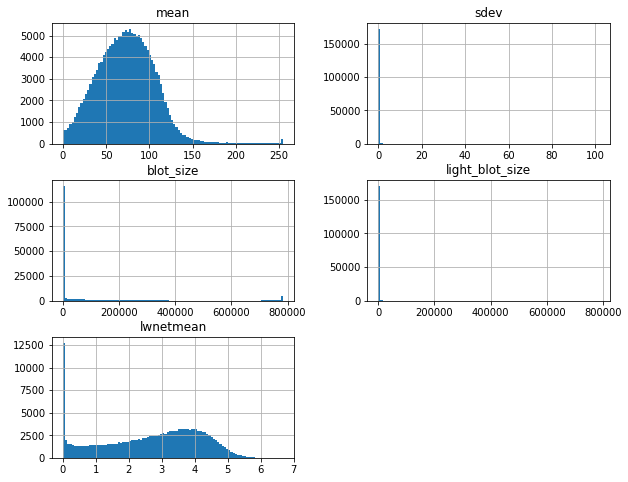

In [596]:
#stats = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/newQC_rawStats.csv")
stats = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/rawStats.csv", index_col=0)
stats = stats.set_index("file")
stats['lwnetmean'] = lwnetMean['mean'].loc[stats.index]

#stats = stats[0:3000]
stats.shape
f=stats.hist(bins=100, figsize=(10,8))


In [603]:
print("RAW IMAGES", stats.shape[0])

throw_bright = stats[stats['mean'] > MAX_MEAN]
keep_bright = stats[stats['mean'] <= MAX_MEAN]
print('too bright',throw_bright.shape[0])
keep_sdev, throw_sdev = keep_throw(keep_bright, 'sdev', MAX_SDEV)
print('too high SD',throw_sdev.shape[0])
keep_blots, throw_blots = keep_throw(keep_sdev, 'blot_size', MAX_BLOTSIZE)
print('too much blot',throw_blots.shape[0])

keep_vasculature, throw_vasculature = keep_throw(keep_blots, 'lwnetmean', MIN_VASCULATURE, lower=False)
print('too few lwnet vasculature',throw_vasculature.shape[0])

keep, throw_lightblots = keep_throw(keep_vasculature, 'light_blot_size', MAX_LIGHTBLOTSIZE, lower=True)
print('too much light blot',throw_lightblots.shape[0])

#remove double images for same visit
double_imgs=[]
for i in keep.index:
    if i.split("_")[3] == "1.png":
        first_img = i.split("_1.png")[0]+"_0.png"
        if first_img in keep.index:
            double_imgs.append(first_img)

keep=keep.drop(double_imgs)


print("# double images removed",len(double_imgs))

keep_parts=set([i.split("_")[0] for i in keep.index])
keep_files = set(keep.index)

print("REMAINING images", keep.shape[0])

RAW IMAGES 173814
too bright 1529
too high SD 22928
too much blot 31683
too few lwnet vasculature 16906
too much light blot 2696
# double images removed 177
REMAINING images 97868


Unnamed: 0         1261.000000
mean                 86.501518
sdev                  0.332165
blot_size             0.000000
light_blot_size       0.000000
lwnetmean             2.152177
Name: 1051874_21016_0_1.png, dtype: float64


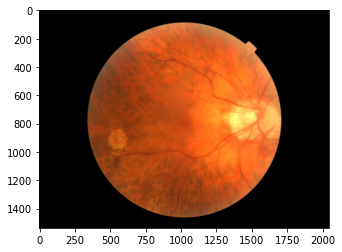

In [573]:
fileinfo("1051874_21016_0_1.png")

AttributeError: 'Rectangle' object has no property 'ylim'

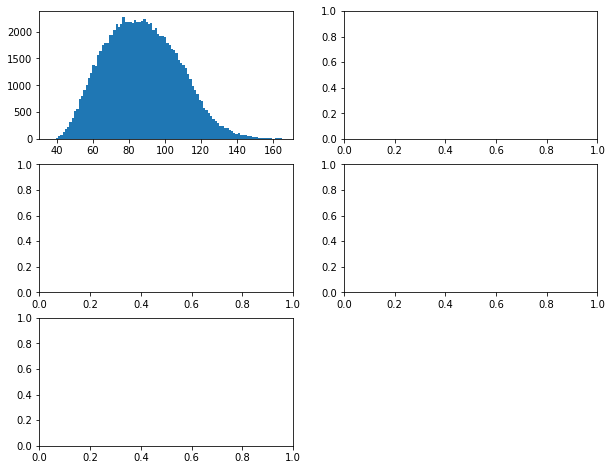

In [601]:
keep.hist(bins=100, figsize=(10,8))

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'mean'}>],
       [<AxesSubplot:title={'center':'sdev'}>,
        <AxesSubplot:title={'center':'blot_size'}>],
       [<AxesSubplot:title={'center':'light_blot_size'}>,
        <AxesSubplot:title={'center':'lwnetmean'}>]], dtype=object)

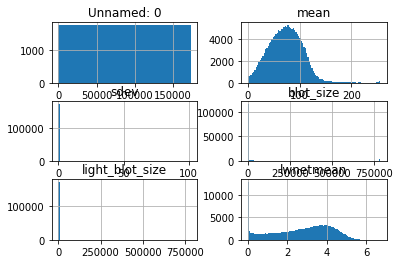

In [575]:
stats.hist(bins=100)

(97868, 6)


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'mean'}>],
       [<AxesSubplot:title={'center':'sdev'}>,
        <AxesSubplot:title={'center':'blot_size'}>],
       [<AxesSubplot:title={'center':'light_blot_size'}>,
        <AxesSubplot:title={'center':'lwnetmean'}>]], dtype=object)

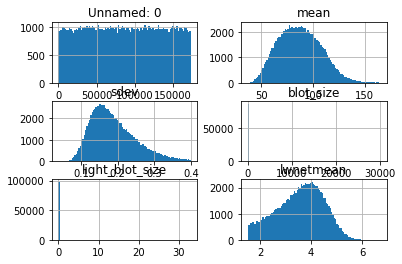

In [577]:
explore = keep
explore=explore.sort_values("light_blot_size",ascending=False)
print(explore.shape)
explore.hist(bins=100)

17
Unnamed: 0         1905.000000
mean                115.777374
sdev                  0.177512
blot_size             0.000000
light_blot_size    1428.000000
lwnetmean             4.354424
Name: 1070426_21016_0_1.png, dtype: float64


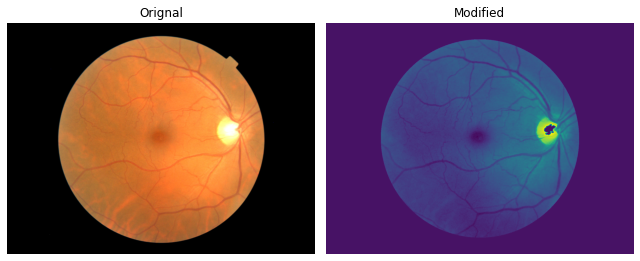

In [556]:
i = i+1
#i = "1035157_21015_0_0.png"
print(i)
#print(explore.loc[i])
print(explore.iloc[i])
#img = plt.imread(rawdir+i)
img=plt.imread(rawdir+explore.index[i])
width = img.shape[1]
height = img.shape[0]
new_size=(int(width*RESIZE_RADIUS/MASK_RADIUS), int(height*RESIZE_RADIUS/MASK_RADIUS))
img = cv2.resize(img, new_size)

gray = mask_image(img, toGray=True)
#gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
nGray = gray.copy()

#quantile = np.quantile(gray[gray.mask==False], BLOT_QUANTILE)
#print(quantile)

#nGray[nGray == 0] = 1
#plt.hist(nGray)
nGray[nGray.mask == True] = 1

nGray[(nGray>0.99) & (nGray.mask == False)] = 0

kernel = np.ones((3, 3), 'uint8')
dilate_img = cv2.erode(nGray, kernel, iterations=1)
view = dilate_img.copy()
view[view==0] = 0.3


#nGray[nGray==0] = 1
compare_image(img,view)

# #binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
# binary = (dilate_img > 0).astype(np.uint8)
# binary = 1-binary
# connectivity = 4
# num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)

# print(np.max(surfaceStats[1:,4]))

[[    281      87     990     953  723794]
 [      0       0    1551    1163 1080019]] 


0


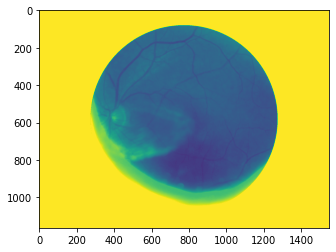

In [487]:
LIGHT_BLOT_THRESHOLD=0.99
DILATION_SIZE=10
o=blot_size(img,lightBlot=True)
print(o)

In [261]:
#binary = cv2.threshold(dilate_img, 0, 255, cv2.THRESH_BINARY)[1]
binary = (dilate_img > 0).astype(np.uint8)
binary = 1-binary
connectivity = 4
num_labels,labels,surfaceStats,centroids = cv2.connectedComponentsWithStats(binary, connectivity, cv2.CV_32S)

In [561]:
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_1bright/", throw_bright.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_2highSD/", throw_sdev.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_3blot/", throw_blots.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_4lwnet/", throw_vasculature.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/throw_5lightblot/", throw_lightblots.index)
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/pass/", keep.index)

In [620]:
mattiaQC = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/mattiaQC_participants.txt", header=None, names=['participants'], dtype=str)
mattiaQC_parts = set(mattiaQC['participants'])

mattiaQC = pd.read_csv("/HDD/data/UKBB/fundus/qcStats/mattiaQC_images.txt", header=None, names=['files'], dtype=str)
mattiaQC_files = set(mattiaQC['files'])
mattiaQC_files = set([i for i in list(mattiaQC_files) if i in stats.index]) # getting rid of withdrawn participants


only_mattiaQC = mattiaQC_files-keep_files
only_newQC = keep_files-mattiaQC_files
print(len(only_mattiaQC), len(only_newQC))


cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/", list(mattiaQC_files)[0:2000])
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/onlyMattiaQC/", list(only_mattiaQC)[0:2000])
cp_content(rawdir, "/HDD/data/UKBB/fundus/qcStats/onlyNewQC/", list(only_newQC)[0:2000])

print('mattiaQC:', len(mattiaQC_parts))
print('newQC:', len(keep_parts))
print('intersect:', len(mattiaQC_parts&keep_parts))

24997 6593
/HDD/data/UKBB/fundus/raw/2820709_21015_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/2820709_21015_0_0.png
/HDD/data/UKBB/fundus/raw/2641441_21015_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/2641441_21015_0_0.png
/HDD/data/UKBB/fundus/raw/4171970_21016_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/4171970_21016_0_0.png
/HDD/data/UKBB/fundus/raw/4949663_21016_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/4949663_21016_0_0.png
/HDD/data/UKBB/fundus/raw/1625568_21015_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/1625568_21015_0_0.png
/HDD/data/UKBB/fundus/raw/2031806_21015_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/2031806_21015_0_0.png
/HDD/data/UKBB/fundus/raw/2932056_21016_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/2932056_21016_0_0.png
/HDD/data/UKBB/fundus/raw/5461581_21015_0_0.png
/HDD/data/UKBB/fundus/qcStats/pass_mattiaQC/5461581_21015_0_0.png
/HDD/data/UKBB/fundus/raw/5674808_21016_1_0.png
/HDD/data/UKBB/fundus/qcStats

In [617]:
df_onlyMattia = stats.loc[only_mattiaQC]
df_onlyNew = stats.loc[only_newQC]
df_mattiaQD = stats.loc[mattiaQC_files]

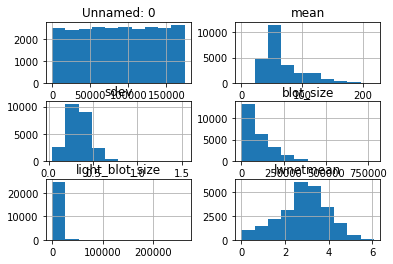

In [582]:
df_onlyMattia.hist();

array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'mean'}>],
       [<AxesSubplot:title={'center':'sdev'}>,
        <AxesSubplot:title={'center':'blot_size'}>],
       [<AxesSubplot:title={'center':'light_blot_size'}>,
        <AxesSubplot:title={'center':'lwnetmean'}>]], dtype=object)

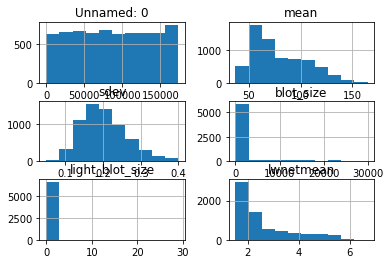

In [583]:
df_onlyNew.hist()

In [ ]:
kernel = np.ones((50,50),np.uint8)
dilation = cv2.dilate(img,kernel,iterations=1)
compare_image(img,dilation)


Error: Kernel is dead

In [ ]:
stats = pd.DataFrame({'file':rawfiles, 'mean':np.nan,'stdev':np.nan,'blot_size':np.nan})

for i,myf in enumerate(rawfiles[0:]):
    img = plt.imread(rawdir+myf)
    width = img.shape[1]
    height = img.shape[0]
    new_size=(int(width*RESIZE_RADIUS/MASK_RADIUS), int(height*RESIZE_RADIUS/MASK_RADIUS))
    print(img.shape)
    img = cv2.resize(img, new_size)
    plt.imshow(img)
    print(img.shape)
    
    hh,ww=img.shape[:2]
    #print(hh//2,ww//2)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask = np.zeros_like(gray)
    mask = cv2.circle(mask, (ww//2,hh//2), RESIZE_RADIUS, (255,255,255), -1)
    #mask = np.invert(mask.astype(bool))

    #result = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    #result[:, :] = mask[:,:]
#    result[:, :, 3] = mask[:,:,0]
    #plt.imshow(result)
    mskd_img=np.ma.array(gray, mask=np.invert(mask.astype(bool)))

    stats['mean'].iloc[i]=mskd_img.mean()*255
    stats['stdev'].iloc[i]=mskd_img.std()*255 / stats['mean'].iloc[i]
    stats['blot_size'].iloc[i]=blot_size(img)

mean               111.316106
sdev                 0.331761
blot_size            0.000000
light_blot_size      0.000000
lwnetmean            1.573771
Name: 1250820_21016_0_0.png, dtype: float64


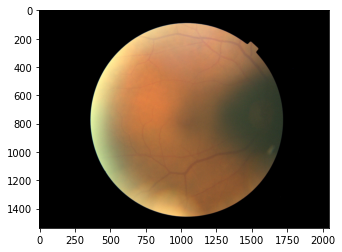

In [611]:
fileinfo("1250820_21016_0_0.png")

In [568]:
"1024825_21016_0_0.png" in mattiaQC_files

True